In [434]:
import torch

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [435]:
df_names = pd.read_csv('data/features.txt', header=None)

In [436]:
names = df_names[0]

In [437]:
idxs = []

for i, name in enumerate(names):
    if 'Mean' in name or 'STD' in name:
        idxs.append(i)

In [438]:
def load_data(path, idxs, type_="train"):
    data_path = path + "/T" + type_[1:] + "/X_" + type_ + ".txt"
    labels_path = path + "/T" + type_[1:] + "/y_" + type_ + ".txt"
    subjects_path = path + "/T" + type_[1:] + "/subject_id_" + type_ + ".txt"
    
    data = pd.read_csv(data_path, sep=" ", header=None)
    labels = pd.read_csv(labels_path, sep=" ", header=None)
    subjects = pd.read_csv(subjects_path, sep=" ", header=None)
    
    data = data[idxs]
    
    data["subject"] = subjects
    data["labels"] = labels
    
    return data

In [477]:
def find_change(array):
    count_ = 0
    changes = []
    len_ = len(array)
    for i in range(len_):             
        if i < len_-3:
            value_current = array[i]
            value_ahead = array[i+1]

            if value_current!=value_ahead:
                changes.append(i)
    return changes


def find_idx(data):
    subjects = np.unique(data.subject)
    changes_global = np.array([])
    for subject in subjects:
        local = data[data.subject==subject]
        local = local.reset_index(drop=True)

        changes_ = find_change(local.labels)
        changes_ = np.append([0], changes_)
        start = 0
        len_ = len(changes_)
        changes_local = np.array([])
        while True:
            changes_local = np.append(changes_local, changes_[start:start+4])
            start += 2
            if start > len_-4:
                break
        changes_global = np.append(changes_global, changes_local)       
    return changes_global


def prepare_idx(changes_global):
    max_len = 20
    
    changes_global = changes_global.reshape(changes_global.shape[0]//4, 4)
    changes_global[:, 0] += 1
    changes_global[0, 0] -= 1
    
    changes_global_final = []   

    for i, change in enumerate(changes_global):
        len_ = change[3] - change[0]
        diff = len_ - max_len
        if diff > 0:
            if ((changes_global[i][1]-changes_global[i][0])<max_len) and (changes_global[i][1]-changes_global[i][0])>0:
                changes_global_final.append([changes_global[i][0], changes_global[i][1], changes_global[i][2], changes_global[i][0] + max_len])
            #else:
            #    changes_global_final.append([changes_global[i][0], changes_global[i][0] + max_len, changes_global[i][0] + max_len, changes_global[i][0] + max_len])

    return changes_global_final


def prepare_data(data, changes_global_final):
    max_len = int(changes_global_final[0][3] - changes_global_final[0][0])
    train_set = torch.tensor([])

    for i, change in enumerate(changes_global_final):
        start, end = int(change[0]), int(change[3])
        element = data[start:end].to_numpy()[:, :len(idxs)]
        if len(train_set) == 0:
            train_set = torch.tensor(element)
        else:
            train_set = torch.cat([train_set, torch.tensor(element)])
            
    train_set = train_set.reshape(len(train_set)//max_len, max_len, len(idxs))
    return train_set


def prepare_labels(changes_global_final):
    labels = []
    max_len = int(changes_global_final[0][3] - changes_global_final[0][0])
    
    for change in changes_global_final:
        position = int(change[2]-change[0])
        if position < max_len:
            labels_local = np.append(np.zeros(position), np.ones(max_len-position))
            labels.append(labels_local)
    return torch.tensor(labels, dtype=torch.int)

def preprocess(data):
    changes_global = find_idx(data)
    changes_global_final = prepare_idx(changes_global)
    set_ = prepare_data(data, changes_global_final)
    labels = prepare_labels(changes_global_final)
    return set_, labels

In [478]:
%%time

data_train = load_data("./data", idxs, type_="train")
train_features, train_labels = preprocess(data_train)

data_test = load_data("./data/", idxs, type_="test")
test_features, test_labels = preprocess(data_test)

CPU times: user 2.78 s, sys: 12 ms, total: 2.8 s
Wall time: 1.24 s


In [479]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import norm
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from sklearn.metrics import average_precision_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
torch.manual_seed(1);

In [480]:
import os
SEQ_LEN = 20
IM_SIZE = len(idxs)

In [481]:
all_data = np.vstack((train_features, test_features))
all_labels = np.vstack((train_labels, test_labels))

In [482]:
all_data.shape

(319, 20, 79)

In [483]:
train_data, val_data, train_labels, val_labels = train_test_split(all_data, all_labels, 
                                                                    test_size=0.2, shuffle=True,
                                                                    random_state=42)

test_data = val_data
test_labels = val_labels
#test_data, val_data, test_labels, val_labels = train_test_split(test_data, test_labels, 
#                                                                test_size=0.5, shuffle=True,
#                                                                random_state=42)

ValueError: Found input variables with inconsistent numbers of samples: [319, 245]

In [446]:
print(train_data.shape)
print(val_data.shape)
print(test_data.shape)

(255, 20, 79)
(64, 20, 79)
(64, 20, 79)


In [447]:
!nvidia-smi

Thu May 27 18:28:00 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:01:00.0 Off |                  N/A |
| 23%   30C    P8     8W / 250W |   5270MiB / 11177MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:02:00.0 Off |                  N/A |
| 29%   

In [448]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
device = torch.device('cuda:0')

In [449]:
def loss_delay_detection_2(p_slice):
    n = p_slice.size(0)
    prod = torch.ones(n).to(device)
    p_slice = p_slice.to(device)
    prod[1:] -= p_slice[:-1]
    cumprod = torch.cumprod(prod, dim=0).to(device)
    loss = torch.arange(1, n + 1).to(device) * p_slice * cumprod
    loss = torch.sum(loss)
    return loss


def loss_delay_detection(p_slice, w):
    n = p_slice.size(0) 
    prod = torch.ones(n).to(device)
    p_slice = p_slice.to(device)
    
    prod[1:] -= p_slice[:-1].to(device)
    cumprod = torch.cumprod(prod, dim=0).to(device)
    # TODO drop either n or w
    loss = (torch.arange(1, n + 1).to(device) * p_slice * cumprod 
            + (w + 1) * torch.prod(prod[1:]) * (1 - p_slice[-1]))
    loss = torch.sum(loss)
    return loss

def loss_false_alarms(p_slice):
    length = len(p_slice)
    loss = 0
    
    start_ind = 0
    end_ind = 0

    #mb it should be recommented
    
    #while end_ind < length:
    #    start_ind = end_ind - 1
    #    if start_ind < 0:
    #        start_ind = 0
    #    end_ind = np.random.randint(start_ind, length + 2)
    #    if end_ind == start_ind:
    #        end_ind = end_ind + 1
    #    loss += 1 - loss_delay_detection_2(p_slice[start_ind: end_ind + 1])

    loss += 1 - loss_delay_detection_2(p_slice[start_ind: length])            
    #loss = torch.sum(loss)
    return loss

In [450]:
class CustomLoss(nn.Module):
    
    def __init__(self):
        super(CustomLoss, self).__init__()
        
    def forward(self, outputs, labels):
        loss = torch.zeros(labels.size(0))
        for i, label in enumerate(labels):
            ind = torch.where(label != label[0])[0]
            if ind.size()[0] == 0:
                loss[i] = loss_false_alarms(outputs[i, :])
            else:
                w = 16
                alpha = 0.5
                loss[i] = (alpha * loss_delay_detection(outputs[i, ind[0]:(ind[0] + w)], w) + 
                           (1 - alpha) * loss_false_alarms(outputs[i, :ind[0]]))
        loss = torch.mean(loss)
        return loss

In [451]:
# input data parameters
input_size = len(idxs)
output_size = SEQ_LEN
seq_len = SEQ_LEN

# model hyperparameters
hidden_dim = 8
n_layers = 1
num_workers = 1
learning_rate = 1e-4

batch_size = 16

In [452]:
def prepare_loader(data, labels, seq_len, input_size, batch_size, shuffle=True, num_workers=1):
    data = torch.FloatTensor(data)
    labels = torch.FloatTensor(labels)
    data = data.view(-1, seq_len, input_size)
    labels = labels.view(-1, seq_len)

    all_data = TensorDataset(data, labels) 
    data_loader = DataLoader(all_data, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
    
    return data_loader

In [453]:
train_loader = prepare_loader(train_data, train_labels, seq_len, input_size, batch_size, shuffle=True)
val_loader = prepare_loader(val_data, val_labels, seq_len, input_size, batch_size, shuffle=False)
test_loader = prepare_loader(test_data, test_labels, seq_len, input_size, batch_size, shuffle=False)

In [454]:
def train_model(model, loss_function, epochs=100, print_every=30, LSTM_flag=False, RNN_flag=False):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    valid_loss_min = np.Inf

    loss_list = []
    acc_list = []
    overall_val_loss_list = []
    counter = 0
    model.train()

    out_list = []
    labels_list = []

    model.train()
    for i in range(epochs):
        # for inputs, labels in tqdm(train_loader):
        for inputs, labels in train_loader:
            if inputs.shape[0] < batch_size:
                break

            counter += 1
            inputs, labels = inputs.to(device), labels.to(device)  

            if LSTM_flag:
                h = model.init_hidden(batch_size)
                h = tuple([e.data for e in h])
                output, h = model(inputs, h)
            elif RNN_flag:
                h = model.init_hidden(batch_size)
                h = torch.stack([e.data for e in h])
                h = torch.zeros(2, batch_size, hidden_dim).to(device)
                output, h = model(inputs, h)                
            else:
                output = model(inputs)

            loss = loss_function(output.squeeze(), labels.float())
            loss_list += [loss.cpu().clone().detach()]
            accuracy = (output > 0.5).long() == labels
            acc_list += [accuracy.cpu().detach().float().mean()]
            out_list.append(output.cpu().detach().float())
            labels_list.append(labels.cpu().detach().float())

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            if counter%print_every == 0:
                val_losses = []
                val_outputs = []
                model.eval()
                for val_inputs, val_labels in val_loader:
                    if val_inputs.shape[0] < batch_size:
                        break
                    val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)

                    if LSTM_flag:
                        val_h = model.init_hidden(batch_size)
                        val_h = tuple([each.data for each in val_h])
                        val_out, val_h = model(val_inputs, val_h)
                    elif RNN_flag:
                        val_h = model.init_hidden(batch_size)
                        val_h = torch.stack([each.data for each in val_h])
                        val_h = torch.zeros(2, batch_size, hidden_dim).to(device)
                        val_out, val_h = model(val_inputs, val_h)
                    else:
                        val_out = model(val_inputs)
                        
                    val_loss = loss_function(val_out.squeeze(), val_labels.float())
                    val_losses.append(val_loss.item())
                    val_outputs += [val_out.cpu().clone().detach()]

                val_outputs_one = torch.cat(val_outputs, 0)

                overall_val_loss_list.append(np.mean(val_losses))

                model.train()
                print("Epoch: {}/{}...".format(i+1, epochs),
                      "Step: {}...".format(counter),
                      "Loss: {:.6f}...".format(loss.item()),
                      "Val Loss: {:.6f}".format(np.mean(val_losses)))
    return model, (loss_list, acc_list, overall_val_loss_list)

In [455]:
!rm -rf experiments
!mkdir experiments

### LSTM Model

In [456]:
class LSTM(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers, drop_prob=0.1):
        
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim        
        # if batch_first, than shape of lstm_in: [batch_size, seq_len, input_size]
        self.lstm = nn.LSTM(input_size, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(drop_prob)
        self.linear_1 = nn.Linear(hidden_dim, 1)        
        #self.linear_1 = nn.Linear(hidden_dim, hidden_dim//2)
        #self.linear_2 = nn.Linear(hidden_dim//2, 1)
        self.activation = nn.Sigmoid()
        self.relu = nn.ReLU()
        
    def forward(self, input_seq, hidden):
        batch_size = input_seq.size(0)
        lstm_out, hidden = self.lstm(input_seq, hidden)  
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)   
        out = self.dropout(lstm_out)        
        out = self.linear_1(out)
        #out = self.relu(out)
        #out = self.linear_2(out)
        out = self.activation(out)
        out = out.view(batch_size, -1)

        return out, hidden

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden

In [458]:
model_LSTM_custom = LSTM(input_size=input_size, output_size=output_size, hidden_dim=hidden_dim, n_layers=n_layers)
loss_function = CustomLoss()
model_LSTM_custom.to(device)

/home/eromanenkova/anaconda3/lib/python3.7/site-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


LSTM(
  (lstm): LSTM(79, 8, batch_first=True, dropout=0.1)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear_1): Linear(in_features=8, out_features=1, bias=True)
  (activation): Sigmoid()
  (relu): ReLU()
)

In [ ]:
model_LSTM_custom, (loss_list, acc_list, 
                    overall_val_loss_list) = train_model(model_LSTM_custom, loss_function, 1, 5, LSTM_flag=True)

model_LSTM_custom = model_LSTM_custom.eval() 
torch.save(model_LSTM_custom, "experiments/model_LSTM_custom.pth")


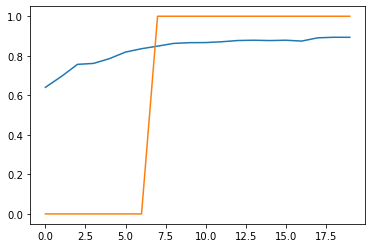

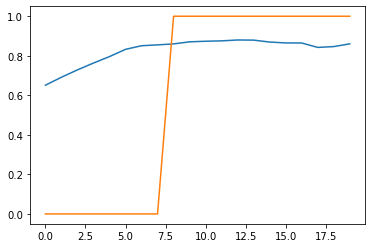

In [153]:
model_LSTM_bce = LSTM(input_size=input_size, output_size=output_size, hidden_dim=hidden_dim, n_layers=n_layers)
bce_loss_function = torch.nn.BCELoss()
model_LSTM_bce.to(device)

/home/eromanenkova/anaconda3/lib/python3.7/site-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


LSTM(
  (lstm): LSTM(79, 8, batch_first=True, dropout=0.1)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear_1): Linear(in_features=8, out_features=4, bias=True)
  (linear_2): Linear(in_features=4, out_features=1, bias=True)
  (activation): Sigmoid()
  (relu): ReLU()
)

In [154]:
model_LSTM_bce, (bce_loss_list, bce_acc_list, bce_overall_val_loss_list) = train_model(model_LSTM_bce, bce_loss_function, 
                                                                                       60, 5, LSTM_flag=True)
model_LSTM_bce = model_LSTM_bce.eval()
torch.save(model_LSTM_bce, "experiments/model_LSTM_bce.pth")

Epoch: 1/60... Step: 5... Loss: 0.696742... Val Loss: 0.692147
Epoch: 1/60... Step: 10... Loss: 0.707942... Val Loss: 0.689824
Epoch: 1/60... Step: 15... Loss: 0.673837... Val Loss: 0.687633
Epoch: 2/60... Step: 20... Loss: 0.669226... Val Loss: 0.685652
Epoch: 2/60... Step: 25... Loss: 0.677193... Val Loss: 0.683710
Epoch: 2/60... Step: 30... Loss: 0.666987... Val Loss: 0.681478
Epoch: 3/60... Step: 35... Loss: 0.684540... Val Loss: 0.679252
Epoch: 3/60... Step: 40... Loss: 0.690297... Val Loss: 0.676915
Epoch: 3/60... Step: 45... Loss: 0.659840... Val Loss: 0.674625
Epoch: 4/60... Step: 50... Loss: 0.664906... Val Loss: 0.672346
Epoch: 4/60... Step: 55... Loss: 0.672051... Val Loss: 0.670205
Epoch: 4/60... Step: 60... Loss: 0.664990... Val Loss: 0.667919
Epoch: 5/60... Step: 65... Loss: 0.657786... Val Loss: 0.664854
Epoch: 5/60... Step: 70... Loss: 0.660652... Val Loss: 0.661053
Epoch: 5/60... Step: 75... Loss: 0.655203... Val Loss: 0.658440
Epoch: 6/60... Step: 80... Loss: 0.648886

Epoch: 42/60... Step: 630... Loss: 0.445353... Val Loss: 0.492893
Epoch: 43/60... Step: 635... Loss: 0.469748... Val Loss: 0.483126
Epoch: 43/60... Step: 640... Loss: 0.409494... Val Loss: 0.486011
Epoch: 43/60... Step: 645... Loss: 0.441029... Val Loss: 0.497871
Epoch: 44/60... Step: 650... Loss: 0.541360... Val Loss: 0.483702
Epoch: 44/60... Step: 655... Loss: 0.484858... Val Loss: 0.485147
Epoch: 44/60... Step: 660... Loss: 0.488277... Val Loss: 0.508301
Epoch: 45/60... Step: 665... Loss: 0.500103... Val Loss: 0.481911
Epoch: 45/60... Step: 670... Loss: 0.473545... Val Loss: 0.481688
Epoch: 45/60... Step: 675... Loss: 0.453863... Val Loss: 0.493832
Epoch: 46/60... Step: 680... Loss: 0.416127... Val Loss: 0.478556
Epoch: 46/60... Step: 685... Loss: 0.476218... Val Loss: 0.475455
Epoch: 46/60... Step: 690... Loss: 0.459680... Val Loss: 0.478979
Epoch: 47/60... Step: 695... Loss: 0.475883... Val Loss: 0.489450
Epoch: 47/60... Step: 700... Loss: 0.479337... Val Loss: 0.484295
Epoch: 47/

In [155]:
batch, labels = next(iter(val_loader))
batch = batch.to(device)

hidden = model_LSTM_bce.init_hidden(batch.shape[0])
hidden = tuple([each.data for each in hidden])

predictions = model_LSTM_bce(batch, hidden)

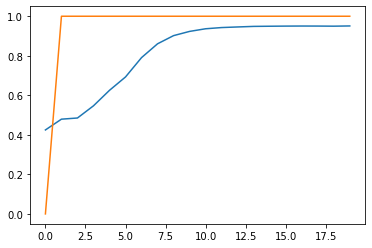

In [166]:
i = 4
plt.plot(predictions[0][i].detach().cpu().numpy())
plt.plot(labels[i].detach().cpu().numpy())
#plt.plot(batch[i][:, 0].detach().cpu().numpy());


In [27]:
model_LSTM_combined = LSTM(input_size=input_size, output_size=output_size, hidden_dim=hidden_dim, n_layers=n_layers)
first_bce_loss_function = torch.nn.BCELoss()
second_custom_loss_function = CustomLoss()
model_LSTM_combined.to(device)

LSTM(
  (lstm): LSTM(561, 8, num_layers=2, batch_first=True, dropout=0.1)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear_1): Linear(in_features=8, out_features=4, bias=True)
  (linear_2): Linear(in_features=4, out_features=1, bias=True)
  (activation): Sigmoid()
  (relu): ReLU()
)

In [28]:
model_LSTM_combined, _ = train_model(model_LSTM_combined, first_bce_loss_function, 60, 5, 
                                    LSTM_flag=True)

model_LSTM_combined, _ = train_model(model_LSTM_combined, second_custom_loss_function, 60, 5, 
                                    LSTM_flag=True)


model_LSTM_combined = model_LSTM_combined.eval()
torch.save(model_LSTM_combined, "experiments/model_LSTM_combined.pth")

Epoch: 1/60... Step: 5... Loss: 0.726997... Val Loss: 0.737780
Epoch: 1/60... Step: 10... Loss: 0.700505... Val Loss: 0.736609
Epoch: 1/60... Step: 15... Loss: 0.743389... Val Loss: 0.735519
Epoch: 2/60... Step: 20... Loss: 0.711873... Val Loss: 0.734623
Epoch: 2/60... Step: 25... Loss: 0.696280... Val Loss: 0.733829
Epoch: 2/60... Step: 30... Loss: 0.740528... Val Loss: 0.732986
Epoch: 3/60... Step: 35... Loss: 0.716664... Val Loss: 0.732239
Epoch: 3/60... Step: 40... Loss: 0.738906... Val Loss: 0.731449
Epoch: 3/60... Step: 45... Loss: 0.718116... Val Loss: 0.730650
Epoch: 3/60... Step: 50... Loss: 0.709947... Val Loss: 0.730002
Epoch: 4/60... Step: 55... Loss: 0.706433... Val Loss: 0.729269
Epoch: 4/60... Step: 60... Loss: 0.701946... Val Loss: 0.728429
Epoch: 4/60... Step: 65... Loss: 0.739407... Val Loss: 0.727711
Epoch: 5/60... Step: 70... Loss: 0.717565... Val Loss: 0.726742
Epoch: 5/60... Step: 75... Loss: 0.725410... Val Loss: 0.725809
Epoch: 5/60... Step: 80... Loss: 0.739737

### RNN

In [29]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers, drop_prob=0.5):
        
        super(RNN, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim        
        # if batch_first, than shape of lstm_in: [batch_size, seq_len, input_size]
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(drop_prob)
        self.linear_1 = nn.Linear(hidden_dim, hidden_dim//2)
        self.linear_2 = nn.Linear(hidden_dim//2, 1)
        self.activation = nn.Sigmoid()
        self.relu = nn.ReLU()
        
    def forward(self, input_seq, hidden):
        batch_size = input_seq.size(0)
        rnn_out, hidden = self.rnn(input_seq, hidden)  
        rnn_out = rnn_out.contiguous().view(-1, self.hidden_dim)      
        out = self.linear_1(rnn_out)
        out = self.dropout(out)
        out = self.relu(out)
        out = self.linear_2(out)
        out = self.activation(out)
        out = out.view(batch_size, -1)

        return out, hidden

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden

In [36]:
model_RNN_custom = RNN(input_size=input_size, output_size=output_size, hidden_dim=hidden_dim, n_layers=n_layers)
loss_function = CustomLoss()
model_RNN_custom.to(device)

RNN(
  (rnn): RNN(561, 8, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (linear_1): Linear(in_features=8, out_features=4, bias=True)
  (linear_2): Linear(in_features=4, out_features=1, bias=True)
  (activation): Sigmoid()
  (relu): ReLU()
)

In [37]:
model_RNN_custom, (loss_list, acc_list, 
                    overall_val_loss_list) = train_model(model_RNN_custom, loss_function, 60, 5, RNN_flag=True)

model_RNN_custom = model_RNN_custom.eval()
torch.save(model_RNN_custom, "experiments/model_RNN_custom.pth")

Epoch: 1/60... Step: 5... Loss: 0.855848... Val Loss: 0.669192
Epoch: 1/60... Step: 10... Loss: 0.672859... Val Loss: 0.550766
Epoch: 1/60... Step: 15... Loss: 0.626884... Val Loss: 0.532341
Epoch: 2/60... Step: 20... Loss: 0.985925... Val Loss: 0.483860
Epoch: 2/60... Step: 25... Loss: 0.779527... Val Loss: 0.458639
Epoch: 2/60... Step: 30... Loss: 0.468311... Val Loss: 0.433687
Epoch: 3/60... Step: 35... Loss: 0.378672... Val Loss: 0.461589
Epoch: 3/60... Step: 40... Loss: 0.462995... Val Loss: 0.441733
Epoch: 3/60... Step: 45... Loss: 0.368168... Val Loss: 0.361060
Epoch: 3/60... Step: 50... Loss: 0.485599... Val Loss: 0.339771
Epoch: 4/60... Step: 55... Loss: 0.316614... Val Loss: 0.316035
Epoch: 4/60... Step: 60... Loss: 0.064293... Val Loss: 0.203153
Epoch: 4/60... Step: 65... Loss: 0.087678... Val Loss: 0.314708
Epoch: 5/60... Step: 70... Loss: 0.199805... Val Loss: 0.346596
Epoch: 5/60... Step: 75... Loss: 0.231664... Val Loss: 0.244838
Epoch: 5/60... Step: 80... Loss: 0.371318

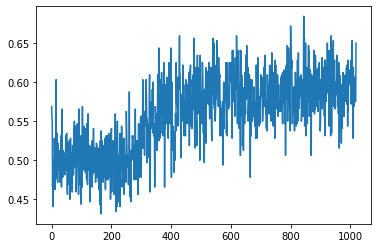

In [38]:
plt.plot(acc_list)

In [39]:
model_RNN_bce = RNN(input_size=input_size, output_size=output_size, hidden_dim=hidden_dim, n_layers=n_layers)
bce_loss_function = torch.nn.BCELoss()
model_RNN_bce.to(device)

RNN(
  (rnn): RNN(561, 8, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (linear_1): Linear(in_features=8, out_features=4, bias=True)
  (linear_2): Linear(in_features=4, out_features=1, bias=True)
  (activation): Sigmoid()
  (relu): ReLU()
)

In [40]:
model_RNN_bce, (bce_loss_list, bce_acc_list, bce_overall_val_loss_list) = train_model(model_RNN_bce, bce_loss_function, 
                                                                                       60, 5, RNN_flag=True)
model_RNN_bce = model_RNN_bce.eval()
torch.save(model_RNN_bce, "experiments/model_RNN_bce.pth")

Epoch: 1/60... Step: 5... Loss: 0.705449... Val Loss: 0.692557
Epoch: 1/60... Step: 10... Loss: 0.700015... Val Loss: 0.692981
Epoch: 1/60... Step: 15... Loss: 0.704064... Val Loss: 0.693735
Epoch: 2/60... Step: 20... Loss: 0.703331... Val Loss: 0.694257
Epoch: 2/60... Step: 25... Loss: 0.699423... Val Loss: 0.694853
Epoch: 2/60... Step: 30... Loss: 0.702685... Val Loss: 0.695046
Epoch: 3/60... Step: 35... Loss: 0.693484... Val Loss: 0.695409
Epoch: 3/60... Step: 40... Loss: 0.700474... Val Loss: 0.695369
Epoch: 3/60... Step: 45... Loss: 0.705110... Val Loss: 0.694803
Epoch: 3/60... Step: 50... Loss: 0.704278... Val Loss: 0.693809
Epoch: 4/60... Step: 55... Loss: 0.709038... Val Loss: 0.693266
Epoch: 4/60... Step: 60... Loss: 0.690751... Val Loss: 0.692674
Epoch: 4/60... Step: 65... Loss: 0.697359... Val Loss: 0.692061
Epoch: 5/60... Step: 70... Loss: 0.688427... Val Loss: 0.691694
Epoch: 5/60... Step: 75... Loss: 0.690227... Val Loss: 0.691606
Epoch: 5/60... Step: 80... Loss: 0.701118

In [41]:
model_RNN_combined = RNN(input_size=input_size, output_size=output_size, hidden_dim=hidden_dim, n_layers=n_layers)
first_bce_loss_function = torch.nn.BCELoss()
second_custom_loss_function = CustomLoss()
model_RNN_combined.to(device)

RNN(
  (rnn): RNN(561, 8, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (linear_1): Linear(in_features=8, out_features=4, bias=True)
  (linear_2): Linear(in_features=4, out_features=1, bias=True)
  (activation): Sigmoid()
  (relu): ReLU()
)

In [42]:
model_RNN_combined, (bce_loss_list, bce_acc_list, bce_overall_val_loss_list) = train_model(model_RNN_combined, first_bce_loss_function, 60, 5, 
                                    RNN_flag=True)

model_RNN_combined, (bce_loss_list, bce_acc_list, bce_overall_val_loss_list) = train_model(model_RNN_combined, second_custom_loss_function, 60, 5, 
                                    RNN_flag=True)

model_RNN_combined = model_RNN_combined.eval()
torch.save(model_RNN_combined, "experiments/model_RNN_combined.pth")

Epoch: 1/60... Step: 5... Loss: 0.719680... Val Loss: 0.706406
Epoch: 1/60... Step: 10... Loss: 0.677854... Val Loss: 0.702864
Epoch: 1/60... Step: 15... Loss: 0.696247... Val Loss: 0.700487
Epoch: 2/60... Step: 20... Loss: 0.688427... Val Loss: 0.697147
Epoch: 2/60... Step: 25... Loss: 0.698697... Val Loss: 0.695192
Epoch: 2/60... Step: 30... Loss: 0.699685... Val Loss: 0.694175
Epoch: 3/60... Step: 35... Loss: 0.685136... Val Loss: 0.693335
Epoch: 3/60... Step: 40... Loss: 0.692990... Val Loss: 0.691590
Epoch: 3/60... Step: 45... Loss: 0.687122... Val Loss: 0.690257
Epoch: 3/60... Step: 50... Loss: 0.690853... Val Loss: 0.689083
Epoch: 4/60... Step: 55... Loss: 0.701092... Val Loss: 0.688688
Epoch: 4/60... Step: 60... Loss: 0.687134... Val Loss: 0.688019
Epoch: 4/60... Step: 65... Loss: 0.687812... Val Loss: 0.687343
Epoch: 5/60... Step: 70... Loss: 0.689548... Val Loss: 0.686369
Epoch: 5/60... Step: 75... Loss: 0.688544... Val Loss: 0.685650
Epoch: 5/60... Step: 80... Loss: 0.682014

### GRU

In [43]:
class GRU(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers, drop_prob=0.5):
        
        super(GRU, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim        
        # if batch_first, than shape of lstm_in: [batch_size, seq_len, input_size]
        self.gru = nn.GRU(input_size, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(drop_prob)
        self.linear_1 = nn.Linear(hidden_dim, hidden_dim//2)
        self.linear_2 = nn.Linear(hidden_dim//2, 1)
        self.activation = nn.Sigmoid()
        self.relu = nn.ReLU()
        
    def forward(self, input_seq, hidden):
        batch_size = input_seq.size(0)
        gru_out, hidden = self.gru(input_seq, hidden)  
        gru_out = gru_out.contiguous().view(-1, self.hidden_dim)      
        out = self.linear_1(gru_out)
        out = self.dropout(out)
        out = self.relu(out)
        out = self.linear_2(out)
        out = self.activation(out)
        out = out.view(batch_size, -1)

        return out, hidden

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden

In [44]:
model_GRU_custom = GRU(input_size=input_size, output_size=output_size, hidden_dim=hidden_dim, n_layers=n_layers)
loss_function = CustomLoss()
model_GRU_custom.to(device)

GRU(
  (gru): GRU(561, 8, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (linear_1): Linear(in_features=8, out_features=4, bias=True)
  (linear_2): Linear(in_features=4, out_features=1, bias=True)
  (activation): Sigmoid()
  (relu): ReLU()
)

In [45]:
model_GRU_custom, (loss_list, acc_list, 
                    overall_val_loss_list) = train_model(model_GRU_custom, loss_function, 60, 5, RNN_flag=True)

model_GRU_custom = model_GRU_custom.eval()
torch.save(model_GRU_custom, "experiments/model_GRU_custom.pth")

Epoch: 1/60... Step: 5... Loss: 0.345438... Val Loss: 0.444715
Epoch: 1/60... Step: 10... Loss: 0.494014... Val Loss: 0.568452
Epoch: 1/60... Step: 15... Loss: 0.323978... Val Loss: 0.506600
Epoch: 2/60... Step: 20... Loss: -0.059977... Val Loss: 0.422942
Epoch: 2/60... Step: 25... Loss: -0.047119... Val Loss: 0.460765
Epoch: 2/60... Step: 30... Loss: 0.027082... Val Loss: 0.449628
Epoch: 3/60... Step: 35... Loss: 0.560062... Val Loss: 0.345873
Epoch: 3/60... Step: 40... Loss: 0.275810... Val Loss: 0.331942
Epoch: 3/60... Step: 45... Loss: -0.105161... Val Loss: 0.340160
Epoch: 3/60... Step: 50... Loss: 0.061737... Val Loss: 0.317403
Epoch: 4/60... Step: 55... Loss: 0.412539... Val Loss: 0.232014
Epoch: 4/60... Step: 60... Loss: 0.366840... Val Loss: 0.290224
Epoch: 4/60... Step: 65... Loss: -0.070730... Val Loss: 0.185579
Epoch: 5/60... Step: 70... Loss: 0.100022... Val Loss: 0.157687
Epoch: 5/60... Step: 75... Loss: -0.176286... Val Loss: 0.261993
Epoch: 5/60... Step: 80... Loss: -0.

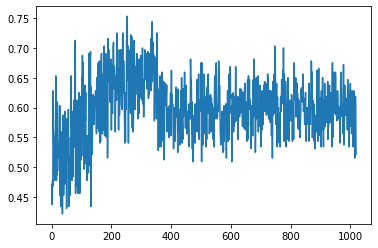

In [46]:
plt.plot(acc_list)

In [47]:
model_GRU_bce = GRU(input_size=input_size, output_size=output_size, hidden_dim=hidden_dim, n_layers=n_layers)
bce_loss_function = torch.nn.BCELoss()
model_GRU_bce.to(device)

GRU(
  (gru): GRU(561, 8, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (linear_1): Linear(in_features=8, out_features=4, bias=True)
  (linear_2): Linear(in_features=4, out_features=1, bias=True)
  (activation): Sigmoid()
  (relu): ReLU()
)

In [48]:
model_GRU_bce, (bce_loss_list, bce_acc_list, bce_overall_val_loss_list) = train_model(model_GRU_bce, bce_loss_function, 
                                                                                       60, 5, RNN_flag=True)

model_GRU_bce = model_GRU_bce.eval()
torch.save(model_GRU_bce, "experiments/model_GRU_bce.pth")

Epoch: 1/60... Step: 5... Loss: 0.717643... Val Loss: 0.707734
Epoch: 1/60... Step: 10... Loss: 0.697684... Val Loss: 0.705299
Epoch: 1/60... Step: 15... Loss: 0.703181... Val Loss: 0.700004
Epoch: 2/60... Step: 20... Loss: 0.676534... Val Loss: 0.695873
Epoch: 2/60... Step: 25... Loss: 0.682544... Val Loss: 0.686407
Epoch: 2/60... Step: 30... Loss: 0.680458... Val Loss: 0.679524
Epoch: 3/60... Step: 35... Loss: 0.696028... Val Loss: 0.674762
Epoch: 3/60... Step: 40... Loss: 0.681240... Val Loss: 0.672316
Epoch: 3/60... Step: 45... Loss: 0.668775... Val Loss: 0.668585
Epoch: 3/60... Step: 50... Loss: 0.678106... Val Loss: 0.665330
Epoch: 4/60... Step: 55... Loss: 0.655585... Val Loss: 0.663919
Epoch: 4/60... Step: 60... Loss: 0.675609... Val Loss: 0.660508
Epoch: 4/60... Step: 65... Loss: 0.661970... Val Loss: 0.653940
Epoch: 5/60... Step: 70... Loss: 0.662828... Val Loss: 0.656452
Epoch: 5/60... Step: 75... Loss: 0.665078... Val Loss: 0.654398
Epoch: 5/60... Step: 80... Loss: 0.675710

In [49]:
model_GRU_combined = GRU(input_size=input_size, output_size=output_size, hidden_dim=hidden_dim, n_layers=n_layers)
first_bce_loss_function = torch.nn.BCELoss()
second_custom_loss_function = CustomLoss()
model_GRU_combined.to(device)

GRU(
  (gru): GRU(561, 8, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (linear_1): Linear(in_features=8, out_features=4, bias=True)
  (linear_2): Linear(in_features=4, out_features=1, bias=True)
  (activation): Sigmoid()
  (relu): ReLU()
)

In [50]:
model_GRU_combined, (bce_loss_list, bce_acc_list, bce_overall_val_loss_list) = train_model(model_GRU_combined, first_bce_loss_function, 60, 5, 
                                    RNN_flag=True)


model_GRU_combined, (bce_loss_list, bce_acc_list, bce_overall_val_loss_list) = train_model(model_GRU_combined, second_custom_loss_function, 60, 5, 
                                    RNN_flag=True)

model_GRU_combined = model_GRU_combined.eval()
torch.save(model_GRU_combined, "experiments/model_GRU_combined.pth")

Epoch: 1/60... Step: 5... Loss: 0.721765... Val Loss: 0.694601
Epoch: 1/60... Step: 10... Loss: 0.724038... Val Loss: 0.689226
Epoch: 1/60... Step: 15... Loss: 0.683339... Val Loss: 0.685706
Epoch: 2/60... Step: 20... Loss: 0.740093... Val Loss: 0.684404
Epoch: 2/60... Step: 25... Loss: 0.708672... Val Loss: 0.682236
Epoch: 2/60... Step: 30... Loss: 0.671450... Val Loss: 0.680093
Epoch: 3/60... Step: 35... Loss: 0.666986... Val Loss: 0.679399
Epoch: 3/60... Step: 40... Loss: 0.674301... Val Loss: 0.678125
Epoch: 3/60... Step: 45... Loss: 0.681747... Val Loss: 0.676516
Epoch: 3/60... Step: 50... Loss: 0.715550... Val Loss: 0.673151
Epoch: 4/60... Step: 55... Loss: 0.683047... Val Loss: 0.669103
Epoch: 4/60... Step: 60... Loss: 0.667443... Val Loss: 0.665931
Epoch: 4/60... Step: 65... Loss: 0.656649... Val Loss: 0.663744
Epoch: 5/60... Step: 70... Loss: 0.669481... Val Loss: 0.661859
Epoch: 5/60... Step: 75... Loss: 0.667373... Val Loss: 0.659107
Epoch: 5/60... Step: 80... Loss: 0.640564

# Calculate metrics for different models

In [51]:
def evaluate_metrics(y_true, y_pred, threshold=0.5):
    """
    Evaluate metrics for change point detection
    We assume, that there is no more than one change index in data (so, either 0 or 1 change)
    Inputs
    y_true : torch.Tensor
      true labels
    y_pred : torch.Tensor
      change probabiltiy
    threshold : float
      detection threshold
      
    Returns
    false_positive : int
      number of false positives
    false_negative : int
      number of false negatives
    delay : int
      detection delay
    accuracy : float
      y_pred accuracy given y_truei
    """
    delay = 0
    false_positive = 0
    false_negative = 0
    true_negative = 0

    index_real = torch.where(y_true != y_true[0])[0] # indexes with real changes
    index_detected = torch.where((y_pred > threshold).long() != y_true[0])[0] # indexes with predicted changes

    if len(index_real) > 0:
        real_change_index = index_real[0]

        if len(index_detected) > 0:
            index_sub_detected = torch.where(index_detected >= real_change_index)[0]

            if len(index_sub_detected) == len(index_detected):
                false_positive_delay = real_change_index.item()
                detected_change_index = index_detected[0]
                delay = (detected_change_index - real_change_index).item()
            else:
                false_positive_delay = index_detected[0].item()
                delay = 0
                false_positive += 1
                
        else:
            false_positive_delay = seq_len
            delay = (seq_len - real_change_index).item()
            false_negative += 1

    else:
        if len(index_detected) > 0:
            false_positive_delay = index_detected[0].item()
            false_positive += 1
        else:
            false_positive_delay = seq_len
            true_negative += 1
    
    accuracy = ((y_pred > threshold).long() == y_true).float().mean().item()
    
    return false_positive, false_negative, delay, false_positive_delay, accuracy

In [52]:
test_batch_size = 16

In [53]:
def get_quality_metrics(test_loader, model, threshold=0.5, LSTM_flag=False, RNN_flag=False):
    test_loss_list = []
    test_acc_list = []

    positive_number = 0 
    negative_number = 0
    fp_list = []
    fn_list = []
    delay_list = []
    fp_delay_list = []
    accuracy_list = []

    model.eval()
    for test_inputs, test_true_labels in test_loader:
            
        test_inputs, test_true_labels = test_inputs.to(device), test_true_labels.to(device)
        
        if LSTM_flag:
            test_hidden = model.init_hidden(test_batch_size)
            test_hidden = tuple([each.data for each in test_hidden])
            #test_hidden = torch.zeros(1, len(test_inputs), hidden_dim).to(device)
            #test_hidden = tuple([test_hidden, test_hidden])
            test_predictions, test_hidden = model(test_inputs, test_hidden)
        elif RNN_flag:
            test_hidden = torch.zeros(2, len(test_inputs), hidden_dim).to(device)
            test_predictions, test_hidden = model(test_inputs, test_hidden)            
        else:
            test_predictions = model(test_inputs)
            
        test_loss = loss_function(test_predictions.squeeze(), test_true_labels.float())
        test_loss_list += [test_loss.cpu().clone().detach()]

        for i in range(0, test_batch_size):
            curr_labels = test_true_labels[i]
            curr_predictions = test_predictions[i]
            
            # torch.rand_like
            curr_fp, curr_fn, curr_delay, curr_fp_delay, curr_accuracy = evaluate_metrics(curr_labels, curr_predictions, 
                                                                           threshold)

            max_difference = np.abs((curr_labels.max() - curr_labels.min()).item())
            if max_difference: 
                delay_list.append(curr_delay)
            positive_number += (max_difference > 0)
            negative_number += 1 - (max_difference > 0)

            fp_list.append(curr_fp)
            fn_list.append(curr_fn)
            fp_delay_list.append(curr_fp_delay)
            accuracy_list.append(curr_accuracy)

        test_acc_list.append(np.mean(accuracy_list[-test_batch_size:]))
        
    return (positive_number, negative_number, np.mean(test_loss_list), np.mean(test_acc_list), np.mean(delay_list),
            np.mean(fp_delay_list), np.sum(fp_list), np.sum(fn_list))

In [54]:
def get_pareto_metrics_for_threshold(model, test_loader, threshold_list, LSTM_flag=False, RNN_flag=False):
    fp_number_list = []
    fn_number_list = []
    delay_list = []
    fp_delay_list = []
    for threshold in threshold_list:
        # test_loader = prepare_loader(test_data, test_labels, seq_len, input_size, batch_size)

        (positive_number, negative_number, test_loss, 
         test_acc, mean_delay, mean_fp_delay, fp_number, fn_number) = get_quality_metrics(test_loader, model, threshold, LSTM_flag, RNN_flag)

        fp_number_list.append(fp_number)
        fn_number_list.append(fn_number)
        delay_list.append(mean_delay)
        fp_delay_list.append(mean_fp_delay)
        #print(threshold, fp_number, fn_number, mean_delay, mean_fp_delay)
    
    return fp_number_list, fn_number_list, delay_list, fp_delay_list

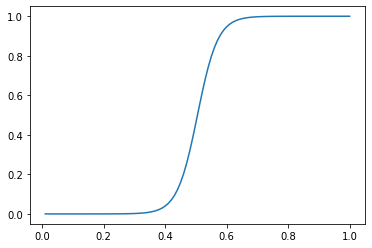

In [68]:
threshold_number = 100
threshold_list = np.linspace(-15, 15, threshold_number)
threshold_list = 1 / (1 + np.exp(-threshold_list))
#threshold_list = np.append([-0.01], threshold_list)
#threshold_list = np.append(threshold_list, [1.01])
plt.plot(np.linspace(0.01, 1, threshold_number), threshold_list)

### Evaluate LSTM

In [167]:
model_LSTM_bce = torch.load("experiments/model_LSTM_bce.pth")
model_LSTM_custom = torch.load("experiments/model_LSTM_custom.pth")
model_LSTM_combined = torch.load("experiments/model_LSTM_combined.pth")

In [69]:
test_batch_size = 4
loss_function = torch.nn.BCELoss()
final_test_loader = prepare_loader(test_data, test_labels, seq_len, input_size, test_batch_size, shuffle=False)

(fp_number_list_LSTM_bce, fn_number_list_LSTM_bce, 
 delay_list_LSTM_bce, fp_delay_list_LSTM_bce) = get_pareto_metrics_for_threshold(model_LSTM_bce, final_test_loader, 
                                                                                 threshold_list, LSTM_flag=True)

In [70]:
test_batch_size = 4
final_test_loader = prepare_loader(test_data, test_labels, seq_len, input_size, test_batch_size, shuffle=False)

(fp_number_list_LSTM_custom, fn_number_list_LSTM_custom, 
 delay_list_LSTM_custom, fp_delay_list_LSTM_custom) = get_pareto_metrics_for_threshold(model_LSTM_custom, final_test_loader, 
                                                                                       threshold_list, LSTM_flag=True)

In [71]:
test_batch_size = 4
final_test_loader = prepare_loader(test_data, test_labels, seq_len, input_size, test_batch_size, shuffle=False)

(fp_number_list_LSTM_combined, fn_number_list_LSTM_combined, delay_list_LSTM_combined, fp_delay_list_LSTM_combined) = get_pareto_metrics_for_threshold(model_LSTM_combined, final_test_loader, threshold_list, LSTM_flag=True)

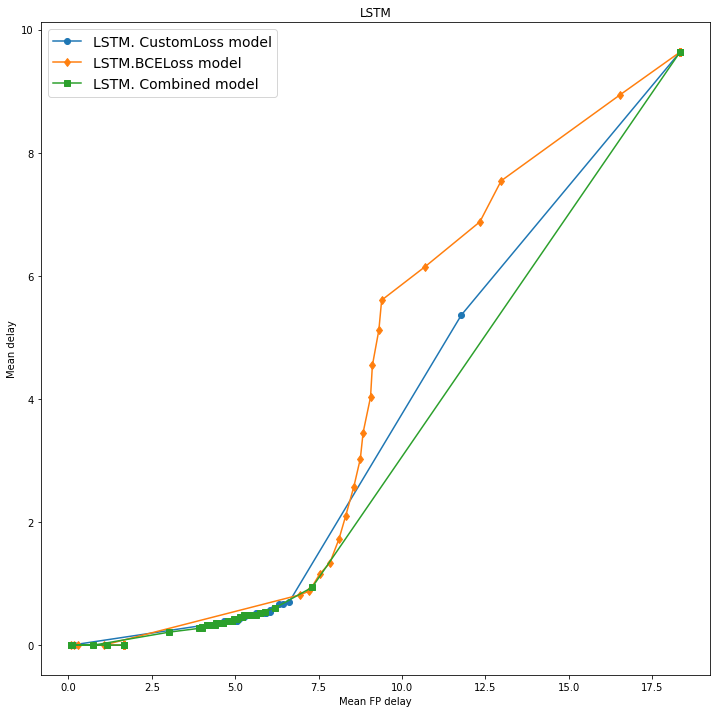

In [72]:
plt.figure(figsize=(12, 12))
plt.plot(fp_delay_list_LSTM_custom, delay_list_LSTM_custom, '-o', label='LSTM. CustomLoss model')
plt.plot(np.array(fp_delay_list_LSTM_bce), np.array(delay_list_LSTM_bce), '-d', label='LSTM.BCELoss model')
plt.plot(fp_delay_list_LSTM_combined, delay_list_LSTM_combined, '-s', label='LSTM. Combined model')

plt.xlabel('Mean FP delay')
plt.ylabel('Mean delay')
plt.title('LSTM')
#plt.yscale('log')
plt.legend(loc='upper left', fontsize=14);

### Evaluate RNN

In [ ]:
model_RNN_bce = torch.load("experiments/model_RNN_bce.pth")
model_RNN_custom = torch.load("experiments/model_RNN_custom.pth")
model_RNN_combined = torch.load("experiments/model_RNN_combined.pth")

In [73]:
test_batch_size = 4
final_test_loader = prepare_loader(test_data, test_labels, seq_len, input_size, test_batch_size, shuffle=False)

(fp_number_list_RNN_bce, fn_number_list_RNN_bce, 
 delay_list_RNN_bce, fp_delay_list_RNN_bce) = get_pareto_metrics_for_threshold(model_RNN_bce, final_test_loader, 
                                                                                 threshold_list, RNN_flag=True)

In [74]:
test_batch_size = 4
final_test_loader = prepare_loader(test_data, test_labels, seq_len, input_size, test_batch_size, shuffle=False)

(fp_number_list_RNN_custom, fn_number_list_RNN_custom, 
 delay_list_RNN_custom, fp_delay_list_RNN_custom) = get_pareto_metrics_for_threshold(model_RNN_custom, final_test_loader, 
                                                                                       threshold_list, RNN_flag=True)

In [75]:
test_batch_size = 4
final_test_loader = prepare_loader(test_data, test_labels, seq_len, input_size, test_batch_size, shuffle=False)

(fp_number_list_RNN_combined, fn_number_list_RNN_combined, delay_list_RNN_combined, fp_delay_list_RNN_combined) = get_pareto_metrics_for_threshold(model_RNN_combined, final_test_loader, threshold_list, RNN_flag=True)

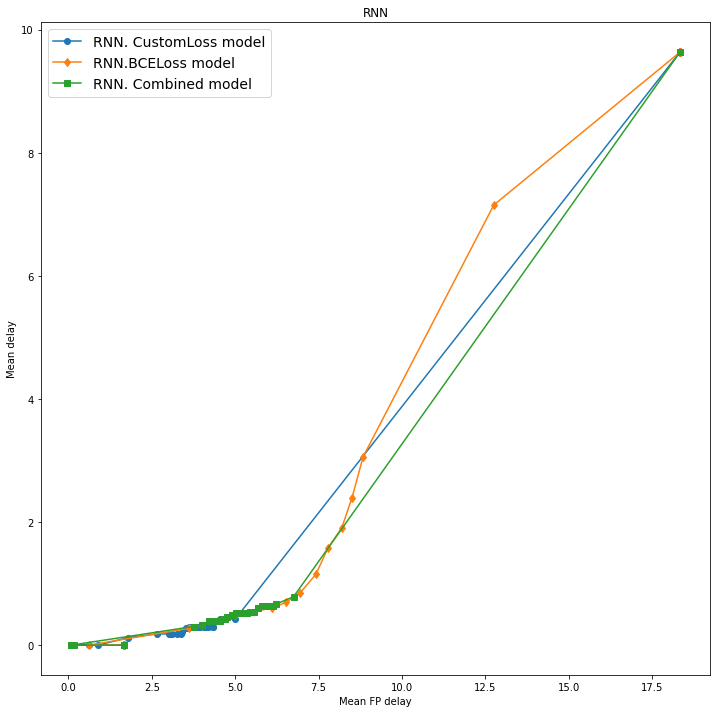

In [76]:
plt.figure(figsize=(12, 12))
plt.plot(fp_delay_list_RNN_custom, delay_list_RNN_custom, '-o', label='RNN. CustomLoss model')
plt.plot(fp_delay_list_RNN_bce, delay_list_RNN_bce, '-d', label='RNN.BCELoss model')
plt.plot(fp_delay_list_RNN_combined, delay_list_RNN_combined, '-s', label='RNN. Combined model')

plt.xlabel('Mean FP delay')
plt.ylabel('Mean delay')
plt.title('RNN')
#plt.yscale('log')
plt.legend(loc='upper left', fontsize=14);

### Evaluate GRU

In [ ]:
model_GRU_bce = torch.load("experiments/model_GRU_bce.pth")
model_GRU_custom = torch.load("experiments/model_GRU_custom.pth")
model_GRU_combined = torch.load("experiments/model_GRU_combined.pth")

In [77]:
test_batch_size = 4
final_test_loader = prepare_loader(test_data, test_labels, seq_len, input_size, test_batch_size, shuffle=False)

(fp_number_list_GRU_bce, fn_number_list_GRU_bce, 
 delay_list_GRU_bce, fp_delay_list_GRU_bce) = get_pareto_metrics_for_threshold(model_GRU_bce, final_test_loader, 
                                                                                 threshold_list, RNN_flag=True)

In [78]:
test_batch_size = 4
final_test_loader = prepare_loader(test_data, test_labels, seq_len, input_size, test_batch_size, shuffle=False)

(fp_number_list_GRU_custom, fn_number_list_GRU_custom, 
 delay_list_GRU_custom, fp_delay_list_GRU_custom) = get_pareto_metrics_for_threshold(model_GRU_custom, final_test_loader, 
                                                                                       threshold_list, RNN_flag=True)

In [79]:
test_batch_size = 4
final_test_loader = prepare_loader(test_data, test_labels, seq_len, input_size, test_batch_size, shuffle=False)

(fp_number_list_GRU_combined, fn_number_list_GRU_combined, delay_list_GRU_combined, fp_delay_list_GRU_combined) = get_pareto_metrics_for_threshold(model_GRU_combined, final_test_loader, threshold_list, RNN_flag=True)

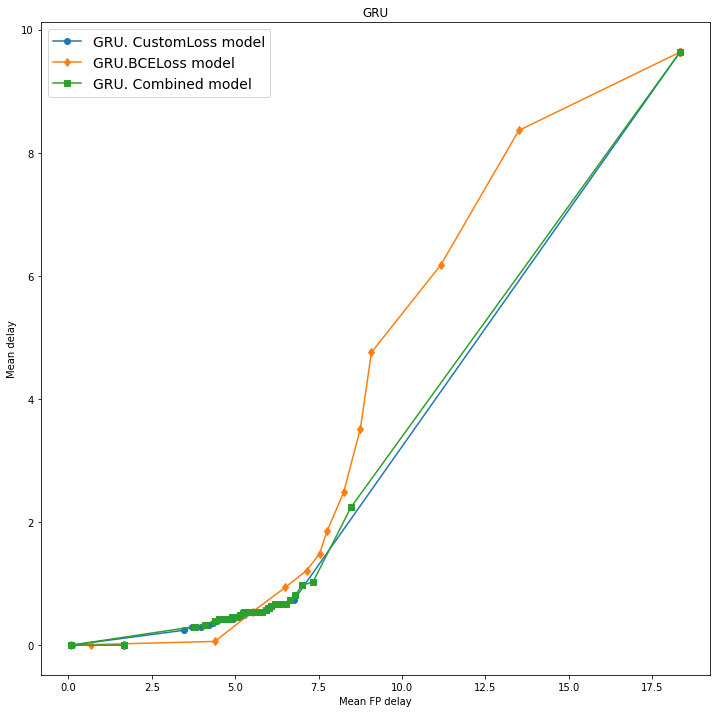

In [80]:
plt.figure(figsize=(12, 12))
plt.plot(fp_delay_list_GRU_custom, delay_list_GRU_custom, '-o', label='GRU. CustomLoss model')
plt.plot(fp_delay_list_GRU_bce, delay_list_GRU_bce, '-d', label='GRU.BCELoss model')
plt.plot(fp_delay_list_GRU_combined, delay_list_GRU_combined, '-s', label='GRU. Combined model')

plt.xlabel('Mean FP delay')
plt.ylabel('Mean delay')
plt.title('GRU')
#plt.yscale('log')
plt.legend(loc='upper left', fontsize=14);